In [1]:
import matplotlib.pyplot as plt
import platform
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error


#### 시각화 한글 설정

In [2]:
# 1. 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (예: colab)
    plt.rcParams['font.family'] = 'NanumGothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

#### 데이터 불러오기 & 전처리

In [3]:
df = pd.read_csv('스마트팜_수정데이터.csv', encoding='euc-kr')

In [4]:
# 필요없는 컬럼 제거
df = df.drop(['체세포', '축종코드', '제조사 아이디', '수집건수', '측정일시'], axis=1)

In [5]:
# 농장아이디, 개체번호 카테고리화
df['개체번호'] = df['개체번호'].astype('category')
df['농장아이디'] = df['농장아이디'].astype('category')

In [6]:
# 혈액흐름 인코딩
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
df['혈액흐름'] = encoder.fit_transform(df[['혈액흐름']])

In [7]:
# 유단백 대비 유지방 컬럼 생성
df['PFR'] = round(df['유단백'] / df['유지방'], 3)

In [8]:
# 착유 소요 시간 컬럼 생성
df['착유시작일시'] = pd.to_datetime(df['착유시작일시'], format='%Y-%m-%d %H:%M')
df['착유종료일시'] = pd.to_datetime(df['착유종료일시'], format='%Y-%m-%d %H:%M')
df['착유소요시간(분)'] = (df['착유종료일시'] - df['착유시작일시']).dt.total_seconds()/60

In [9]:
# 중복 데이터 제거
df = df.drop_duplicates(subset=['착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '혈액흐름', '온도', '유지방', '유단백', '공기흐름', '수집일자', 'PFR', '착유소요시간(분)'], keep='first')

In [10]:
# 결측값 제거
df = df.dropna()

#### EDA

##### 착유량 관련 변수간 상관관계 히트맵

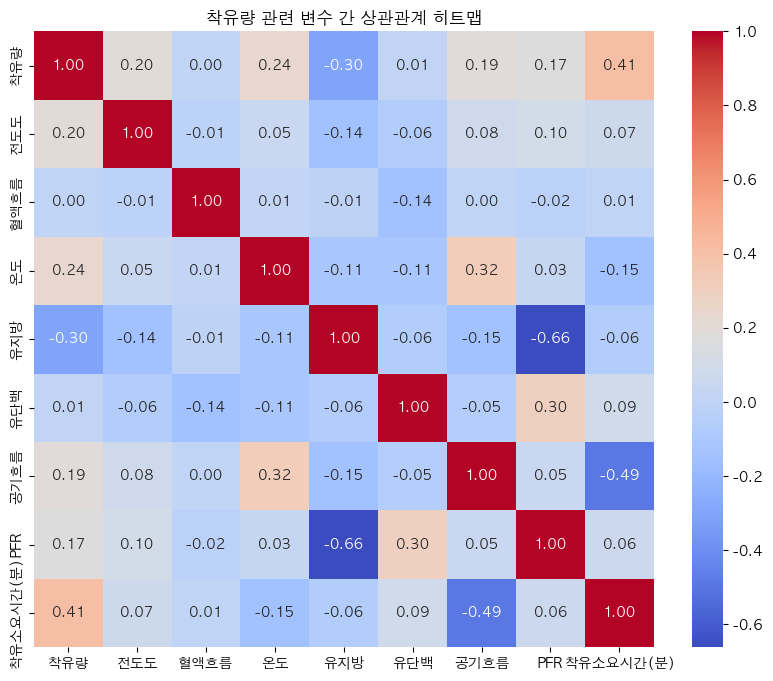

In [11]:
# 분석에 사용할 수치형 변수만 선택
numeric_cols = ['착유량', '전도도', '혈액흐름', '온도', '유지방', '유단백', '공기흐름', 'PFR', '착유소요시간(분)']

# 상관계수 계산
corr = df[numeric_cols].corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("착유량 관련 변수 간 상관관계 히트맵")
plt.show()

##### 수치형 변수 히스토그램 분포

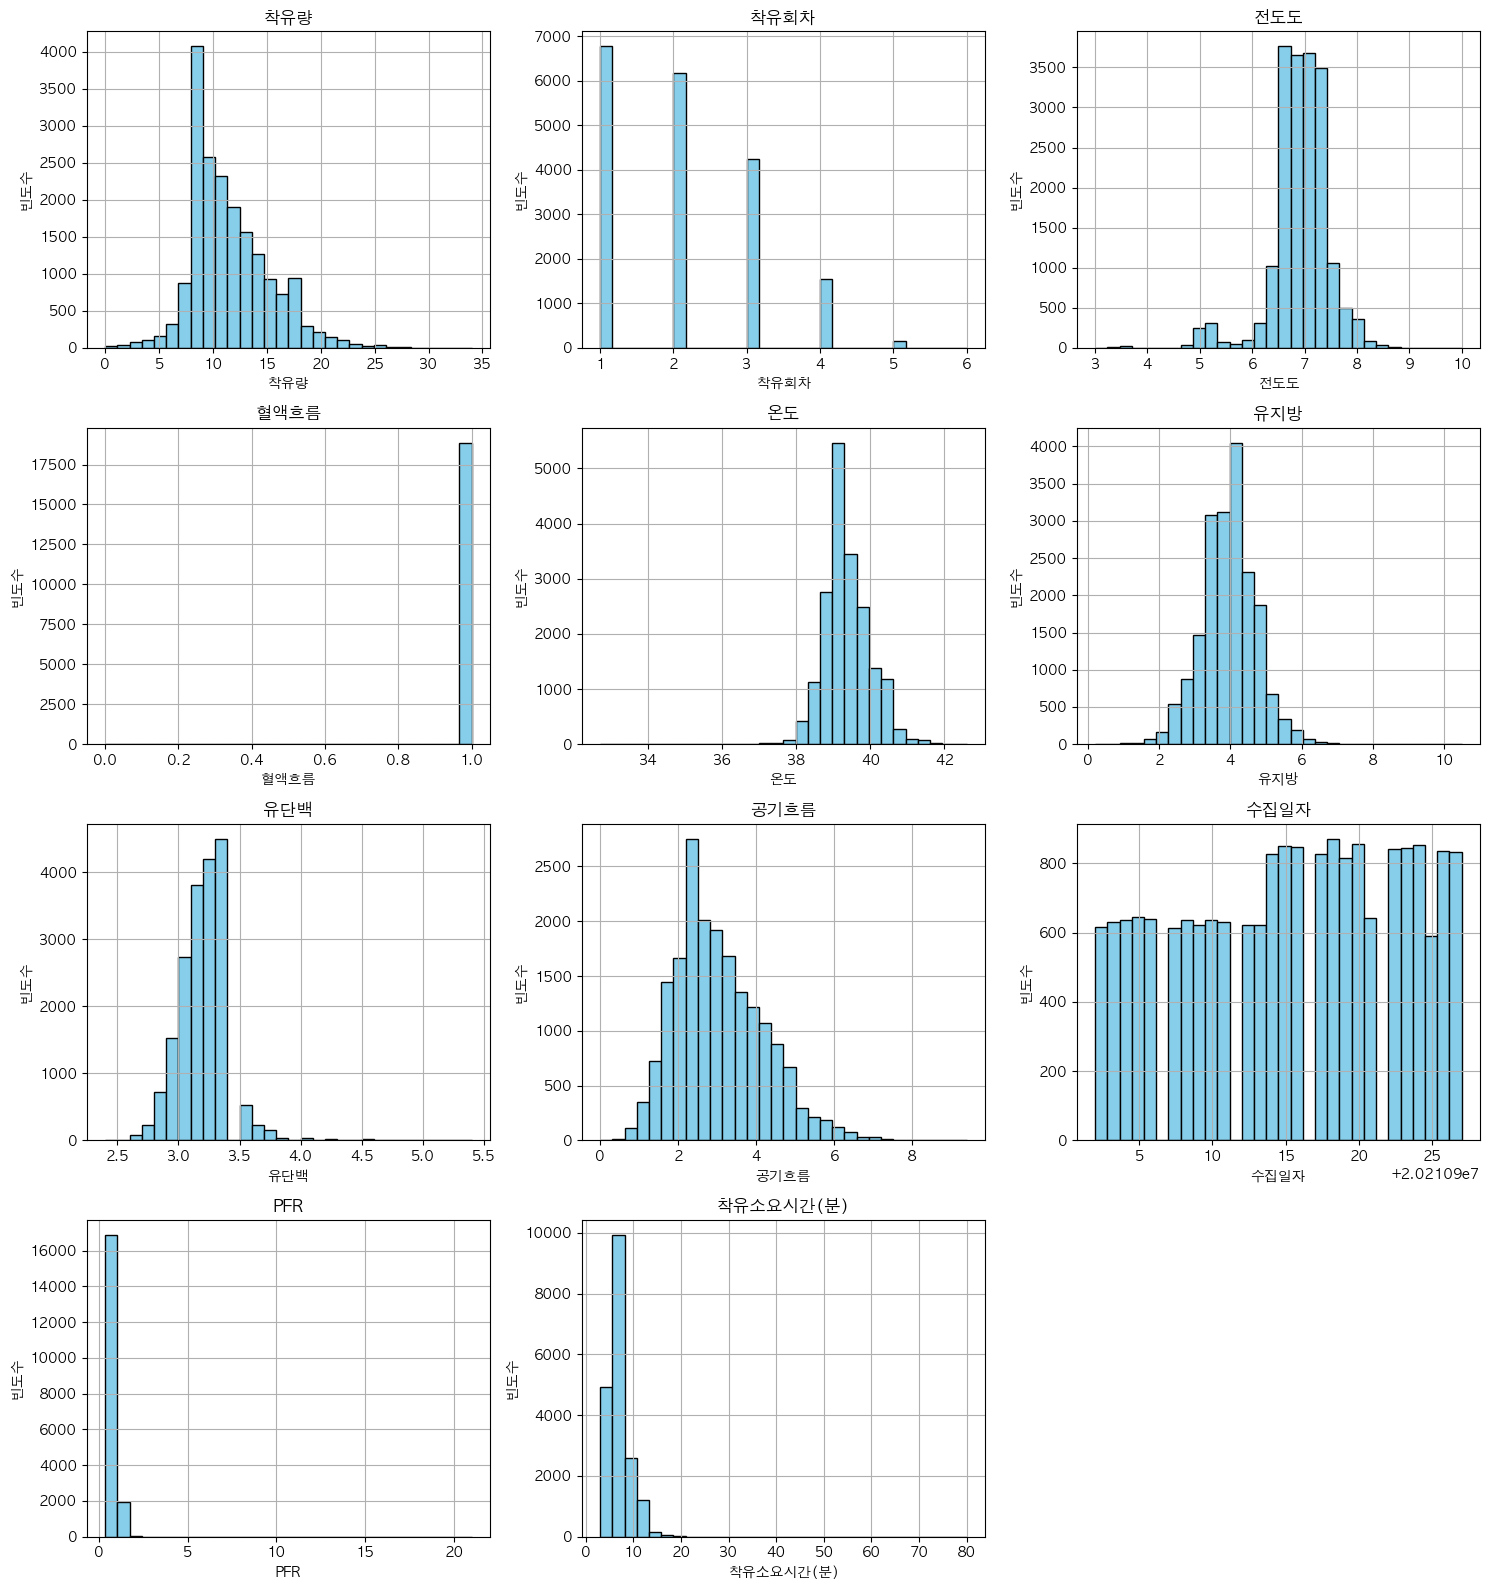

In [12]:
# 수치형 컬럼만 선택
numeric_cols = df.select_dtypes(include=['number']).columns

# 그래프 레이아웃 설정
n_cols = 3  # 열 개수 (가로)
n_rows = -(-len(numeric_cols) // n_cols)  # 행 개수 (ceil 방식)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('빈도수')
    plt.grid(True)

plt.tight_layout()
plt.show()

##### 착유량과 다른 수치형 변수들 간의 산점도

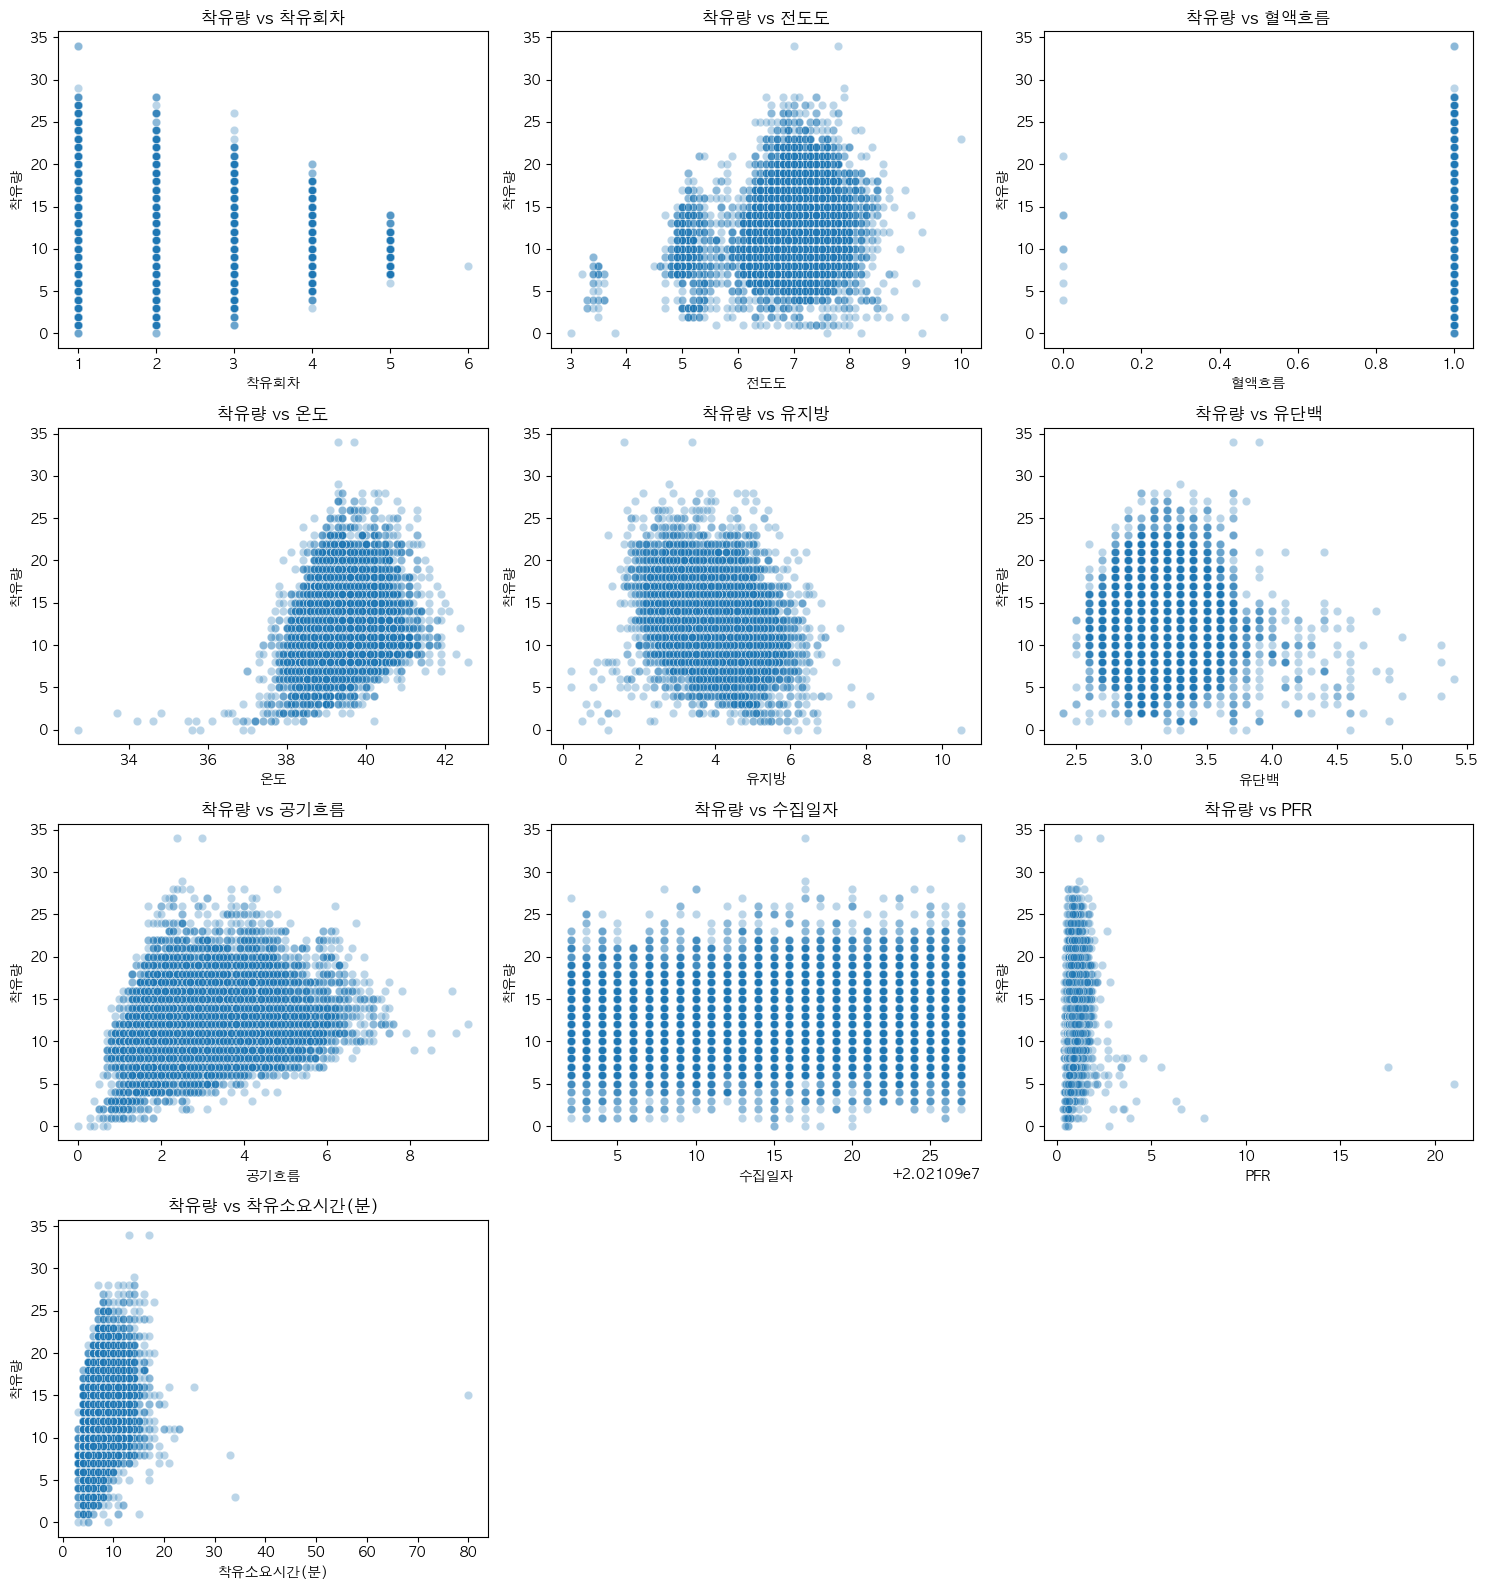

In [13]:
# 수치형 변수만 선택 (착유량 제외)
numeric_cols = df.select_dtypes(include='number').columns.drop('착유량')

# 시각화
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # 올림 나눗셈

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.scatterplot(data=df, x=col, y='착유량', alpha=0.3)
    plt.title(f'착유량 vs {col}')

plt.tight_layout()
plt.show()

### 이상탐지_ isolation forest

#### 기계오류

In [14]:
# 이상탐지에 사용할 컬럼

columns1 = ['공기흐름', '착유소요시간(분)']
machine_detect = df[columns1].copy()

In [15]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)

# 예측 : 1(정상), -1(이상치)
y_pred_machine = iso_forest.fit_predict(machine_detect)

# 이상치로 예측된 샘플 인덱스 추출
outliers_machine = np.where(y_pred_machine == -1)[0]

machine_detect['outliers_machine'] = y_pred_machine

print('=== Isolation Forest ===')
print('이상치로 탐지된 샘플 개수: ', len(outliers_machine))
print('이상치 인덱스: ', outliers_machine)

=== Isolation Forest ===
이상치로 탐지된 샘플 개수:  944
이상치 인덱스:  [   29    35    38    48    53    54    55    56    57    58    59    63
    65    66    67    68    69    71    72    73    74    77    79    81
    82    83    84    85    87    88    89    91    92    93   152   164
   219   227   235   262   384   385   393   399   401   454   897   899
   959   961   962   970   973   976  1597  1793  1794  1795  1935  1954
  1963  1964  1965  1966  1967  1968  1970  1971  1972  1975  1976  1978
  1980  1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993
  1994  1995  1997  1999  2203  2204  2206  2207  2211  2225  2229  2232
  2240  2262  2264  2280  2296  2350  2365  2370  2371  2376  2382  2385
  2388  2556  2615  2828  2833  2853  2954  2969  2972  2978  2987  2994
  2995  2999  3000  3009  3014  3165  3196  3197  3206  3207  3208  3209
  3211  3212  3213  3220  3222  3254  3261  3266  3270  3274  3352  3353
  3366  3369  3371  3373  3375  3410  3433  3452  3453  3503  3686  

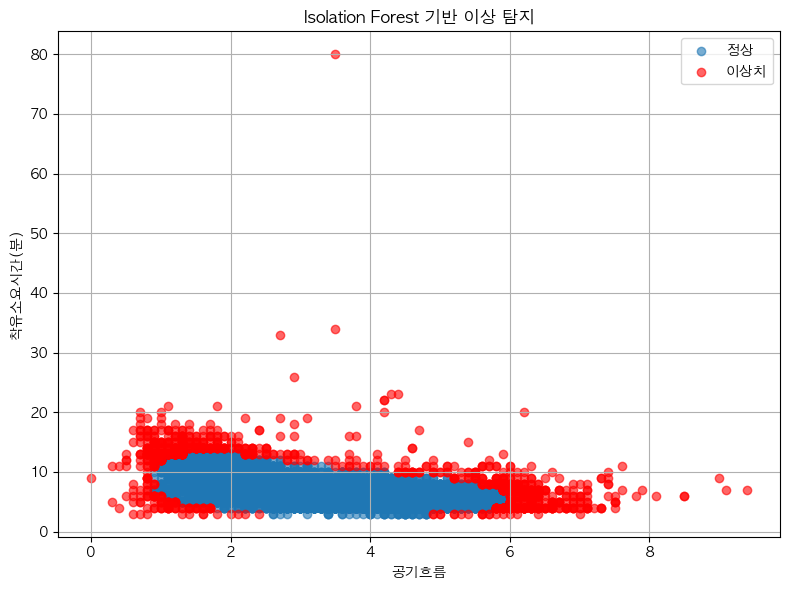

In [16]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    machine_detect[machine_detect['outliers_machine'] == 1]['공기흐름'],
    machine_detect[machine_detect['outliers_machine'] == 1]['착유소요시간(분)'],
    label='정상', alpha=0.6
)
plt.scatter(
    machine_detect[machine_detect['outliers_machine'] == -1]['공기흐름'],
    machine_detect[machine_detect['outliers_machine'] == -1]['착유소요시간(분)'],
    label='이상치', color='red', alpha=0.6
)
plt.xlabel('공기흐름')
plt.ylabel('착유소요시간(분)')
plt.title('Isolation Forest 기반 이상 탐지')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

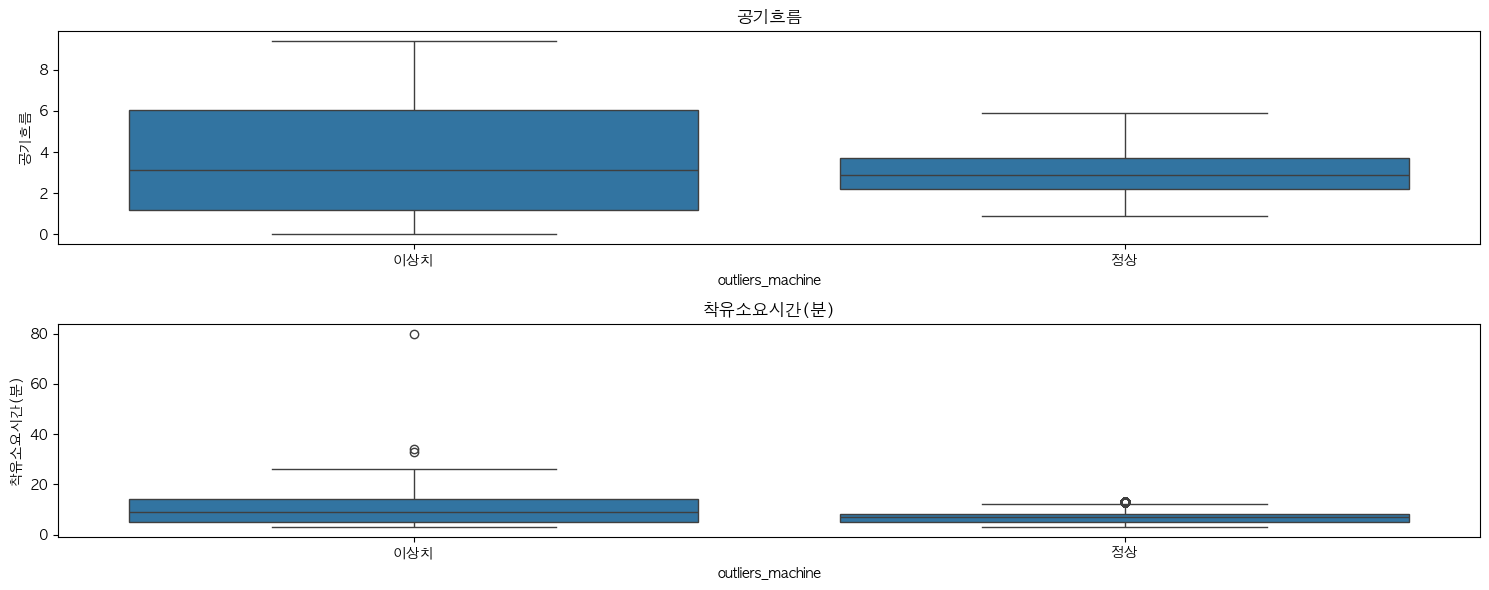

In [17]:
# box plot 시각화

import seaborn as sns

# 정상과 이상치 분리
normal_df = machine_detect[machine_detect['outliers_machine'] == 1]
outlier_df = machine_detect[machine_detect['outliers_machine'] == -1]

# boxplot 비교
plt.figure(figsize=(15, 6))
for i, feature in enumerate(columns1):
    plt.subplot(2, (len(columns1) + 1) // 2, i + 1)
    sns.boxplot(data=machine_detect, x='outliers_machine', y=feature)
    plt.xticks([0, 1], ['이상치', '정상'])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [18]:
machine_detect[machine_detect['outliers_machine'] == 1].describe()

,공기흐름,착유소요시간(분),outliers_machine
count,17930.000000,17930.000000,17930.0
mean,3.016224,6.920190,1.0
std,1.013049,1.946819,0.0
min,0.900000,3.000000,1.0
25%,2.200000,5.000000,1.0
50%,2.900000,7.000000,1.0
75%,3.700000,8.000000,1.0
max,5.900000,13.000000,1.0


#### 건강

In [19]:
# 이상탐지에 사용할 컬럼

columns2 = ['전도도', '온도', 'PFR']
health_detect = df[columns2].copy()

In [20]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01, random_state=42)

# 예측 : 1(정상), -1(이상치)
y_pred_health = iso_forest.fit_predict(health_detect)

# 이상치로 예측된 샘플 인덱스 추출
outliers_health = np.where(y_pred_health == -1)[0]

print('=== Isolation Forest ===')
print('이상치로 탐지된 샘플 개수: ', len(outliers_health))
print('이상치 인덱스: ', outliers_health)

=== Isolation Forest ===
이상치로 탐지된 샘플 개수:  189
이상치 인덱스:  [  589   610   740   847   854   891   892   950   951   952   965  1264
  1397  1407  1412  1419  1420  1421  1422  1423  1424  1429  1430  1431
  1432  1435  1734  1751  1752  1753  1754  1755  1756  1759  1761  1771
  1774  1777  1786  1789  1790  1792  1793  1794  1797  1908  1952  1989
  2045  2069  2350  2368  2371  2372  2376  2384  2388  2978  3009  3014
  3209  3212  3213  3791  3924  4017  4121  4137  4281  4499  4530  4642
  4774  5361  5455  5554  5723  5724  5761  6906  6920  6926  6951  7231
  7232  7233  7234  7235  7236  7238  7239  7240  7248  7255  7256  7258
  7260  7261  7262  7264  7473  7665  7692  8023  8033  8035  8036  8043
  8189  9295  9374  9544  9777  9884  9888  9905  9916  9917  9919  9938
  9939  9941  9942 10025 10028 10029 10030 10031 10852 10855 10859 10860
 10874 10880 10883 10885 10886 10901 10902 10906 11479 11535 11536 11926
 12076 12665 12690 12745 12799 12800 12801 12802 12803 12912 13828 1

In [21]:
# 다변량이기에 시각화를 위해 PCA 차원 축소
# PCA 전에는 스케일링이 꼭 필요

health_detect['outliers_health'] = y_pred_health

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
health_detect_scaled = scaler.fit_transform(health_detect)

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(health_detect_scaled)

# 결과를 원래 DataFrame에 추가
health_detect['pca1'] = pca_result[:, 0]
health_detect['pca2'] = pca_result[:, 1]

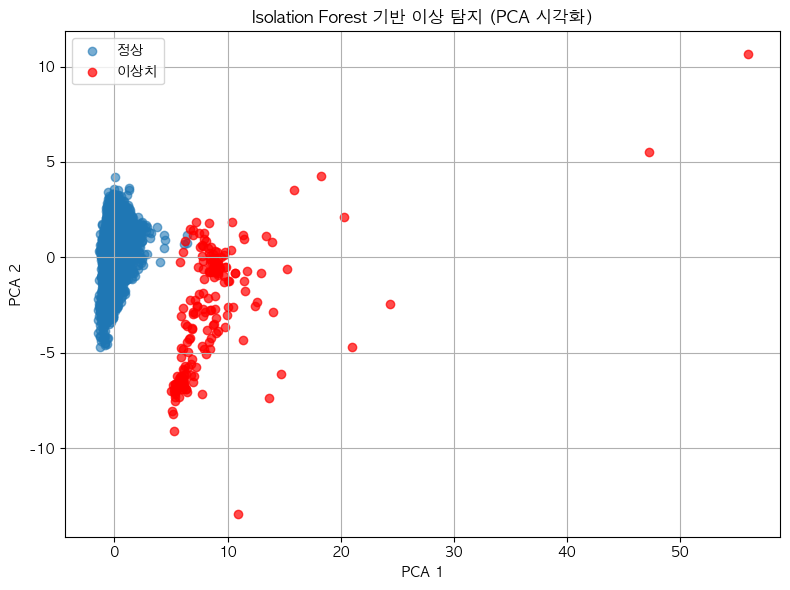

In [22]:
# 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    health_detect[health_detect['outliers_health'] == 1]['pca1'],
    health_detect[health_detect['outliers_health'] == 1]['pca2'],
    label='정상', alpha=0.6
)
plt.scatter(
    health_detect[health_detect['outliers_health'] == -1]['pca1'],
    health_detect[health_detect['outliers_health'] == -1]['pca2'],
    label='이상치', color='red', alpha=0.7
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Isolation Forest 기반 이상 탐지 (PCA 시각화)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

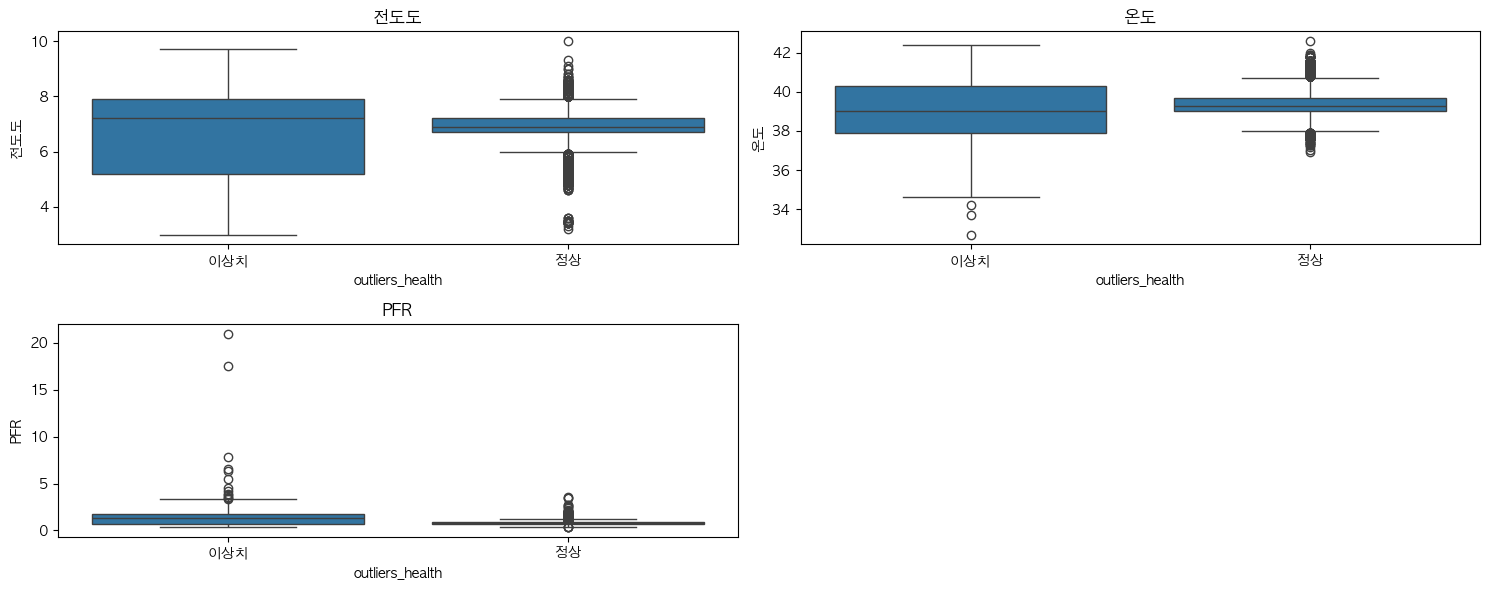

In [23]:
# box plot 시각화

import seaborn as sns

# 정상과 이상치 분리
normal_df = health_detect[health_detect['outliers_health'] == 1]
outlier_df = health_detect[health_detect['outliers_health'] == -1]

# boxplot 비교
plt.figure(figsize=(15, 6))
for i, feature in enumerate(columns2):
    plt.subplot(2, (len(columns2) + 1) // 2, i + 1)
    sns.boxplot(data=health_detect, x='outliers_health', y=feature)
    plt.xticks([0, 1], ['이상치', '정상'])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [24]:
health_detect[health_detect['outliers_health'] == 1].describe()

,전도도,온도,PFR,outliers_health,pca1,pca2
count,18685.000000,18685.000000,18685.000000,18685.0,18685.000000,18685.000000
mean,6.907455,39.367616,0.826989,1.0,-0.088311,0.028914
std,0.535116,0.599414,0.186799,0.0,0.484950,0.949382
min,3.200000,36.900000,0.382000,1.0,-1.487460,-4.686985
25%,6.700000,39.000000,0.705000,1.0,-0.393839,-0.529496
50%,6.900000,39.300000,0.795000,1.0,-0.157315,0.020320
75%,7.200000,39.700000,0.912000,1.0,0.135927,0.624692
max,10.000000,42.600000,3.538000,1.0,6.414109,4.202457


#### 이상탐지 결과를 반영한 데이터 필터링

In [25]:
df_clean = df[machine_detect['outliers_machine'] == 1 & (health_detect['outliers_health'].values  == 1)]

In [26]:
df_clean.describe()

,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,PFR,착유소요시간(분)
count,17796.000000,17796,17796,17796.000000,17796.000000,17796.000000,17796.000000,17796.000000,17796.000000,17796.000000,1.779600e+04,17796.000000,17796.000000
mean,11.510733,2021-09-14 16:24:18.519892224,2021-09-14 16:31:13.671611392,2.068049,6.911233,0.999550,39.369802,3.964475,3.155271,3.018757,2.021092e+07,0.826828,6.919195
min,1.000000,2021-09-01 00:03:00,2021-09-01 00:10:00,1.000000,3.200000,0.000000,37.300000,0.800000,2.500000,0.900000,2.021090e+07,0.382000,3.000000
25%,9.000000,2021-09-08 09:24:15,2021-09-08 09:33:00,1.000000,6.700000,1.000000,39.000000,3.500000,3.000000,2.200000,2.021091e+07,0.705000,5.000000
50%,11.000000,2021-09-15 05:40:00,2021-09-15 05:48:00,2.000000,6.900000,1.000000,39.300000,4.000000,3.200000,2.900000,2.021092e+07,0.795000,7.000000
75%,13.000000,2021-09-21 01:05:45,2021-09-21 01:12:30,3.000000,7.200000,1.000000,39.700000,4.400000,3.300000,3.700000,2.021092e+07,0.912000,8.000000
max,28.000000,2021-09-26 23:55:00,2021-09-27 00:01:00,6.000000,10.000000,1.000000,42.600000,8.100000,5.400000,5.900000,2.021093e+07,3.538000,13.000000
std,3.470058,NaN,NaN,0.995031,0.519476,0.021198,0.593614,0.734572,0.206483,1.011940,7.385787e+00,0.186243,1.946197


#### 비선형 모델 선택 전 비교

In [27]:
columns3 = ['착유회차', '전도도', '혈액흐름', '온도', '유지방', '유단백', '공기흐름', '수집일자', 'PFR', '착유소요시간(분)']

X = df_clean[columns3]
y = df_clean['착유량']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### 랜덤포레스트

In [ ]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train,y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=== RandomForestRegressor 결과 ===")
print(f"train R² : {train_r2:.3f}")
print(f"test R² : {test_r2:.3f}")
print(f"train MAE : {train_mae:.3f}")
print(f"test MAE : {test_mae:.3f}")

=== RandomForestRegressor 결과 ===
train R² : 0.954
test R² : 0.662
train MAE : 0.544
test MAE : 1.519


##### CatBoost

In [29]:
cat = CatBoostRegressor(random_state=42)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))

y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=== CatBoostRegressor 결과 ===")
print(f"train R² : {train_r2:.3f}")
print(f"test R² : {test_r2:.3f}")
print(f"train MAE : {train_mae:.3f}")
print(f"test MAE : {test_mae:.3f}")



Learning rate set to 0.077264
0:	learn: 3.3267636	test: 3.4582689	best: 3.4582689 (0)	total: 3.75ms	remaining: 3.74s
1:	learn: 3.2218406	test: 3.3503769	best: 3.3503769 (1)	total: 13ms	remaining: 6.51s
2:	learn: 3.1253990	test: 3.2518421	best: 3.2518421 (2)	total: 15.2ms	remaining: 5.05s
3:	learn: 3.0401627	test: 3.1664541	best: 3.1664541 (3)	total: 17.5ms	remaining: 4.35s
4:	learn: 2.9662576	test: 3.0909524	best: 3.0909524 (4)	total: 24.9ms	remaining: 4.96s
5:	learn: 2.8945952	test: 3.0207239	best: 3.0207239 (5)	total: 30.3ms	remaining: 5.03s
6:	learn: 2.8326577	test: 2.9601648	best: 2.9601648 (6)	total: 46.5ms	remaining: 6.59s
7:	learn: 2.7698674	test: 2.8984255	best: 2.8984255 (7)	total: 49.6ms	remaining: 6.14s
8:	learn: 2.7125907	test: 2.8415285	best: 2.8415285 (8)	total: 51.9ms	remaining: 5.72s
9:	learn: 2.6648863	test: 2.7956686	best: 2.7956686 (9)	total: 53.1ms	remaining: 5.26s
10:	learn: 2.6195819	test: 2.7500984	best: 2.7500984 (10)	total: 54.4ms	remaining: 4.89s
11:	learn: 2.

##### LightGBM

In [30]:
lgb = LGBMRegressor(random_state=42, n_jobs=-1)

lgb.fit(X_train, y_train)

y_train_pred = lgb.predict(X_train)
y_test_pred = lgb.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=== LGBMRegressor 결과 ===")
print(f"train R² : {train_r2:.3f}")
print(f"test R² : {test_r2:.3f}")
print(f"train MAE : {train_mae:.3f}")
print(f"test MAE : {test_mae:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 14236, number of used features: 9
[LightGBM] [Info] Start training from score 11.505339
=== LGBMRegressor 결과 ===
train R² : 0.749
test R² : 0.678
train MAE : 1.299
test MAE : 1.497


##### XGBoost

In [31]:
xgb = XGBRegressor(random_state=42, verbosity=0)

xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=== XGBRegressor 결과 ===")
print(f"train R² : {train_r2:.3f}")
print(f"test R² : {test_r2:.3f}")
print(f"train MAE : {train_mae:.3f}")
print(f"test MAE : {test_mae:.3f}")

=== XGBRegressor 결과 ===
train R² : 0.831
test R² : 0.671
train MAE : 1.050
test MAE : 1.515


#### CatBoost를 이용한 착유량 예측

In [33]:
# optuna를 이용한 최적의 파라미터 찾기

import optuna

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 2000, 4000),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.07, log=True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 12),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.2, 1.0),
        'border_count': trial.suggest_int('border_count', 135, 200),
        'early_stopping_rounds': 100,
        'use_best_model': True,
        'verbose': False,
        'random_state': 42
    }

    model = CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"[Trial {trial.number}] MAE: {train_mae:.4f} / R2: {train_r2:.4f}")
    print(f"[Trial {trial.number}] MAE: {test_mae:.4f} / R2: {test_r2:.4f}")
    return test_mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best trial:')
trial = study.best_trial
print(trial)

print('Best MAE:', study.best_value)
print('Params: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-08-16 14:48:01,734] A new study created in memory with name: no-name-14fd088e-215a-4c78-9ffe-a03bce0e52a0
[I 2025-08-16 14:48:03,802] Trial 0 finished with value: 1.4822445011104297 and parameters: {'iterations': 3447, 'depth': 5, 'learning_rate': 0.04530678723882455, 'l2_leaf_reg': 12, 'bagging_temperature': 0.5361997361767951, 'border_count': 164}. Best is trial 0 with value: 1.4822445011104297.


[Trial 0] MAE: 1.2726 / R2: 0.7567
[Trial 0] MAE: 1.4822 / R2: 0.6833


[I 2025-08-16 14:48:05,939] Trial 1 finished with value: 1.495416586937521 and parameters: {'iterations': 2260, 'depth': 6, 'learning_rate': 0.014523920099308994, 'l2_leaf_reg': 9, 'bagging_temperature': 0.5622043578643708, 'border_count': 178}. Best is trial 0 with value: 1.4822445011104297.


[Trial 1] MAE: 1.3574 / R2: 0.7215
[Trial 1] MAE: 1.4954 / R2: 0.6771


[I 2025-08-16 14:48:07,598] Trial 2 finished with value: 1.496802618013508 and parameters: {'iterations': 2495, 'depth': 4, 'learning_rate': 0.06037429262007112, 'l2_leaf_reg': 4, 'bagging_temperature': 0.8759688183044103, 'border_count': 162}. Best is trial 0 with value: 1.4822445011104297.


[Trial 2] MAE: 1.2802 / R2: 0.7535
[Trial 2] MAE: 1.4968 / R2: 0.6776


[I 2025-08-16 14:48:11,004] Trial 3 finished with value: 1.4531017745342631 and parameters: {'iterations': 2656, 'depth': 8, 'learning_rate': 0.027355498099729782, 'l2_leaf_reg': 4, 'bagging_temperature': 0.838980128953647, 'border_count': 151}. Best is trial 3 with value: 1.4531017745342631.


[Trial 3] MAE: 1.0680 / R2: 0.8295
[Trial 3] MAE: 1.4531 / R2: 0.6939


[I 2025-08-16 14:48:12,836] Trial 4 finished with value: 1.521016793360043 and parameters: {'iterations': 2638, 'depth': 4, 'learning_rate': 0.017024204402214416, 'l2_leaf_reg': 7, 'bagging_temperature': 0.49147973156578956, 'border_count': 164}. Best is trial 3 with value: 1.4531017745342631.


[Trial 4] MAE: 1.4059 / R2: 0.7002
[Trial 4] MAE: 1.5210 / R2: 0.6672


[I 2025-08-16 14:48:14,448] Trial 5 finished with value: 1.5209656474624411 and parameters: {'iterations': 2427, 'depth': 4, 'learning_rate': 0.0196001327173574, 'l2_leaf_reg': 10, 'bagging_temperature': 0.5456211774390106, 'border_count': 138}. Best is trial 3 with value: 1.4531017745342631.


[Trial 5] MAE: 1.4095 / R2: 0.6984
[Trial 5] MAE: 1.5210 / R2: 0.6670


[I 2025-08-16 14:48:16,504] Trial 6 finished with value: 1.481174031421956 and parameters: {'iterations': 2747, 'depth': 5, 'learning_rate': 0.040382038600558515, 'l2_leaf_reg': 9, 'bagging_temperature': 0.5046622963879328, 'border_count': 135}. Best is trial 3 with value: 1.4531017745342631.


[Trial 6] MAE: 1.2683 / R2: 0.7585
[Trial 6] MAE: 1.4812 / R2: 0.6838


[I 2025-08-16 14:48:20,828] Trial 7 finished with value: 1.4589828505245772 and parameters: {'iterations': 3282, 'depth': 8, 'learning_rate': 0.024303588559361145, 'l2_leaf_reg': 12, 'bagging_temperature': 0.8572725444668957, 'border_count': 137}. Best is trial 3 with value: 1.4531017745342631.


[Trial 7] MAE: 1.1379 / R2: 0.8067
[Trial 7] MAE: 1.4590 / R2: 0.6918


[I 2025-08-16 14:48:22,353] Trial 8 finished with value: 1.4720590366397466 and parameters: {'iterations': 2162, 'depth': 6, 'learning_rate': 0.05209068262829233, 'l2_leaf_reg': 5, 'bagging_temperature': 0.41223726305180214, 'border_count': 138}. Best is trial 3 with value: 1.4531017745342631.


[Trial 8] MAE: 1.2091 / R2: 0.7812
[Trial 8] MAE: 1.4721 / R2: 0.6869


[I 2025-08-16 14:48:25,326] Trial 9 finished with value: 1.4730697741794814 and parameters: {'iterations': 3052, 'depth': 6, 'learning_rate': 0.01890152376154762, 'l2_leaf_reg': 2, 'bagging_temperature': 0.8525936539669473, 'border_count': 139}. Best is trial 3 with value: 1.4531017745342631.


[Trial 9] MAE: 1.2366 / R2: 0.7710
[Trial 9] MAE: 1.4731 / R2: 0.6868


[I 2025-08-16 14:48:30,850] Trial 10 finished with value: 1.4577597669544362 and parameters: {'iterations': 3776, 'depth': 8, 'learning_rate': 0.00897425553722383, 'l2_leaf_reg': 2, 'bagging_temperature': 0.20245238368651486, 'border_count': 153}. Best is trial 3 with value: 1.4531017745342631.


[Trial 10] MAE: 1.1837 / R2: 0.7904
[Trial 10] MAE: 1.4578 / R2: 0.6927


[I 2025-08-16 14:48:36,329] Trial 11 finished with value: 1.4585875423580092 and parameters: {'iterations': 3861, 'depth': 8, 'learning_rate': 0.009338348589239287, 'l2_leaf_reg': 2, 'bagging_temperature': 0.22672605827643788, 'border_count': 151}. Best is trial 3 with value: 1.4531017745342631.


[Trial 11] MAE: 1.1704 / R2: 0.7951
[Trial 11] MAE: 1.4586 / R2: 0.6923


[I 2025-08-16 14:48:38,950] Trial 12 finished with value: 1.4592214241705448 and parameters: {'iterations': 3962, 'depth': 7, 'learning_rate': 0.03021025218773765, 'l2_leaf_reg': 4, 'bagging_temperature': 0.7130645925030819, 'border_count': 197}. Best is trial 3 with value: 1.4531017745342631.


[Trial 12] MAE: 1.1740 / R2: 0.7936
[Trial 12] MAE: 1.4592 / R2: 0.6922


[I 2025-08-16 14:48:42,987] Trial 13 finished with value: 1.4729543395030442 and parameters: {'iterations': 3520, 'depth': 7, 'learning_rate': 0.011025881272064908, 'l2_leaf_reg': 6, 'bagging_temperature': 0.20143149336466942, 'border_count': 153}. Best is trial 3 with value: 1.4531017745342631.


[Trial 13] MAE: 1.2748 / R2: 0.7562
[Trial 13] MAE: 1.4730 / R2: 0.6871


[I 2025-08-16 14:48:45,964] Trial 14 finished with value: 1.4510994031938762 and parameters: {'iterations': 2946, 'depth': 8, 'learning_rate': 0.030410285217898826, 'l2_leaf_reg': 3, 'bagging_temperature': 0.7052700450943872, 'border_count': 151}. Best is trial 14 with value: 1.4510994031938762.


[Trial 14] MAE: 1.0767 / R2: 0.8264
[Trial 14] MAE: 1.4511 / R2: 0.6941


[I 2025-08-16 14:48:48,694] Trial 15 finished with value: 1.4609147118552388 and parameters: {'iterations': 2839, 'depth': 7, 'learning_rate': 0.03285245073078149, 'l2_leaf_reg': 4, 'bagging_temperature': 0.7096162165663602, 'border_count': 173}. Best is trial 14 with value: 1.4510994031938762.


[Trial 15] MAE: 1.1440 / R2: 0.8044
[Trial 15] MAE: 1.4609 / R2: 0.6910


[I 2025-08-16 14:48:51,231] Trial 16 finished with value: 1.4564165037703405 and parameters: {'iterations': 3061, 'depth': 8, 'learning_rate': 0.028143658972467695, 'l2_leaf_reg': 5, 'bagging_temperature': 0.9888915392380409, 'border_count': 148}. Best is trial 14 with value: 1.4510994031938762.


[Trial 16] MAE: 1.1581 / R2: 0.7993
[Trial 16] MAE: 1.4564 / R2: 0.6916


[I 2025-08-16 14:48:53,123] Trial 17 finished with value: 1.463416616444179 and parameters: {'iterations': 2928, 'depth': 7, 'learning_rate': 0.038109464508453046, 'l2_leaf_reg': 3, 'bagging_temperature': 0.7033769898131755, 'border_count': 181}. Best is trial 14 with value: 1.4510994031938762.


[Trial 17] MAE: 1.1867 / R2: 0.7898
[Trial 17] MAE: 1.4634 / R2: 0.6907


[I 2025-08-16 14:48:54,607] Trial 18 finished with value: 1.4570148451211455 and parameters: {'iterations': 3262, 'depth': 8, 'learning_rate': 0.06859466842341011, 'l2_leaf_reg': 7, 'bagging_temperature': 0.7831865688370356, 'border_count': 147}. Best is trial 14 with value: 1.4510994031938762.


[Trial 18] MAE: 1.1336 / R2: 0.8077
[Trial 18] MAE: 1.4570 / R2: 0.6926


[I 2025-08-16 14:48:56,902] Trial 19 finished with value: 1.4696488905760852 and parameters: {'iterations': 2051, 'depth': 7, 'learning_rate': 0.023415182797853616, 'l2_leaf_reg': 6, 'bagging_temperature': 0.9960912434234218, 'border_count': 158}. Best is trial 14 with value: 1.4510994031938762.


[Trial 19] MAE: 1.2419 / R2: 0.7689
[Trial 19] MAE: 1.4696 / R2: 0.6884
Best trial:
FrozenTrial(number=14, state=1, values=[1.4510994031938762], datetime_start=datetime.datetime(2025, 8, 16, 14, 48, 42, 987952), datetime_complete=datetime.datetime(2025, 8, 16, 14, 48, 45, 964332), params={'iterations': 2946, 'depth': 8, 'learning_rate': 0.030410285217898826, 'l2_leaf_reg': 3, 'bagging_temperature': 0.7052700450943872, 'border_count': 151}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=4000, log=False, low=2000, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.07, log=True, low=0.008, step=None), 'l2_leaf_reg': IntDistribution(high=12, log=False, low=2, step=1), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.2, step=None), 'border_count': IntDistribution(high=200, log=False, low=135, step=1)}, trial_id=14, value=None)
Best MAE: 1.4510994031938762

In [36]:
final_cat = CatBoostRegressor(random_state=42, iterations=3962, depth=7, learning_rate=0.03021025218773765, l2_leaf_reg=4, bagging_temperature=0.7130645925030819, border_count=197)

final_cat.fit(X_train,y_train)

y_train_pred_final = final_cat.predict(X_train)
y_test_pred_final = final_cat.predict(X_test)

train_r2_final = r2_score(y_train, y_train_pred_final)
test_r2_final = r2_score(y_test, y_test_pred_final)

train_mae_final = mean_absolute_error(y_train, y_train_pred_final)
test_mae_final = mean_absolute_error(y_test, y_test_pred_final)

print("=== CatBoostRegressor 결과 ===")
print(f"train R² : {train_r2_final:.3f}")
print(f"test R² : {test_r2_final:.3f}")
print(f"train MAE : {train_mae_final:.3f}")
print(f"test MAE : {test_mae_final:.3f}")

0:	learn: 3.3940196	total: 2.04ms	remaining: 8.07s
1:	learn: 3.3496732	total: 5.37ms	remaining: 10.6s
2:	learn: 3.3068886	total: 7.22ms	remaining: 9.52s
3:	learn: 3.2666815	total: 9.11ms	remaining: 9.01s
4:	learn: 3.2247089	total: 10.7ms	remaining: 8.49s
5:	learn: 3.1861308	total: 12.1ms	remaining: 7.99s
6:	learn: 3.1494297	total: 13.7ms	remaining: 7.75s
7:	learn: 3.1104438	total: 15.2ms	remaining: 7.52s
8:	learn: 3.0737402	total: 16.8ms	remaining: 7.37s
9:	learn: 3.0383391	total: 18.1ms	remaining: 7.16s
10:	learn: 3.0074429	total: 19.4ms	remaining: 6.96s
11:	learn: 2.9743980	total: 20.8ms	remaining: 6.84s
12:	learn: 2.9435674	total: 22.1ms	remaining: 6.71s
13:	learn: 2.9133139	total: 23.4ms	remaining: 6.59s
14:	learn: 2.8844454	total: 24.6ms	remaining: 6.47s
15:	learn: 2.8574606	total: 25.9ms	remaining: 6.39s
16:	learn: 2.8311124	total: 27.1ms	remaining: 6.28s
17:	learn: 2.8059834	total: 28.2ms	remaining: 6.18s
18:	learn: 2.7800409	total: 29.7ms	remaining: 6.16s
19:	learn: 2.7568664	t

In [37]:
# 중요변수 뽑기

importances = final_cat.feature_importances_
feature_scores = list(zip(X.columns, importances))
important_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)

print("🔎 중요한 변수:")
for feature, score in important_features:
    print(f"{feature}: {score:.4f}")

🔎 중요한 변수:
착유소요시간(분): 32.2471
공기흐름: 27.4079
전도도: 7.5724
PFR: 7.4439
온도: 7.0378
유지방: 5.7074
유단백: 5.0775
착유회차: 4.0775
수집일자: 3.4210
혈액흐름: 0.0074
